# Fragment-Based Drug Design – Fragment Library Visuals

This notebook:
- Generates fragments from example drugs
- Filters fragments using Rule of Three
- Analyses fragment properties
- Visualises:
  - Fragment molecular weight and LogP
  - Fragment scores
  - Valid vs invalid fragments


In [1]:
"""
Fragment-Based Drug Design
==========================
"""

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski
from rdkit.Chem import BRICS, Recap, Scaffolds
from rdkit.Chem import Fragments
from rdkit.Chem import GraphDescriptors  # <- Import for BertzCT
from typing import List, Dict, Optional, Tuple
import pandas as pd
from collections import Counter


class FragmentBasedDesign:
    def __init__(self):
        self.fragment_mw_limit = 300
        self.fragment_hba_limit = 3
        self.fragment_hbd_limit = 3
        self.fragment_logp_limit = 3

    def generate_brics_fragments(self, smiles: str) -> List[str]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return []
        fragments = list(BRICS.BRICSDecompose(mol))
        cleaned_fragments = []
        for frag in fragments:
            cleaned = frag.replace('[*]', '[H]')
            mol_frag = Chem.MolFromSmiles(cleaned)
            if mol_frag:
                cleaned_fragments.append(Chem.MolToSmiles(mol_frag))
        return list(set(cleaned_fragments))

    def calculate_fragment_properties(self, smiles: str) -> Dict[str, float]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {}
        properties = {
            'MolecularWeight': Descriptors.MolWt(mol),
            'LogP': Crippen.MolLogP(mol),
            'HBD': Lipinski.NumHDonors(mol),
            'HBA': Lipinski.NumHAcceptors(mol),
            'TPSA': Descriptors.TPSA(mol),
            'HeavyAtoms': mol.GetNumHeavyAtoms(),
            'RotatableBonds': Lipinski.NumRotatableBonds(mol),
            'AromaticRings': Lipinski.NumAromaticRings(mol),
            'SaturatedRings': Lipinski.NumSaturatedRings(mol),
            'Complexity': GraphDescriptors.BertzCT(mol)  # <- FIXED
        }
        return properties

    def score_fragment(self, smiles: str) -> float:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0.0
        heavy_atoms = mol.GetNumHeavyAtoms()
        if heavy_atoms == 0:
            return 0.0
        logp = Crippen.MolLogP(mol)
        aromatic_rings = Lipinski.NumAromaticRings(mol)
        complexity = GraphDescriptors.BertzCT(mol)  # <- FIXED
        score = (aromatic_rings * 2 + 5) / heavy_atoms
        score -= abs(logp) * 0.1
        score -= complexity / 1000
        return max(0, score)

    def is_valid_fragment(self, smiles: str) -> bool:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        mw = Descriptors.MolWt(mol)
        logp = Crippen.MolLogP(mol)
        hbd = Lipinski.NumHDonors(mol)
        hba = Lipinski.NumHAcceptors(mol)
        rotatable = Lipinski.NumRotatableBonds(mol)
        tpsa = Descriptors.TPSA(mol)
        return mw <= 300 and logp <= 3 and hbd <= 3 and hba <= 3 and rotatable <= 3 and tpsa <= 60

    def filter_fragments(self, fragments: List[str]) -> List[str]:
        return [frag for frag in fragments if self.is_valid_fragment(frag)]

    def generate_fragment_library(self, smiles_list: List[str], method: str = 'brics') -> List[str]:
        all_fragments = set()
        for smiles in smiles_list:
            if method.lower() == 'brics':
                frags = self.generate_brics_fragments(smiles)
            else:
                raise ValueError("Method must be 'brics'")
            all_fragments.update(frags)
        return list(all_fragments)

    def analyze_fragment_library(self, fragments: List[str]) -> pd.DataFrame:
        results = []
        for frag in fragments:
            props = self.calculate_fragment_properties(frag)
            if props:
                props['SMILES'] = frag
                props['IsValid'] = self.is_valid_fragment(frag)
                props['Score'] = self.score_fragment(frag)
                results.append(props)
        df = pd.DataFrame(results)
        return df.sort_values('Score', ascending=False)


## Fragment Library Visualisations

In this section we:
- Plot molecular weight vs LogP for fragments
- Show fragment score distribution
- Compare valid vs invalid fragments


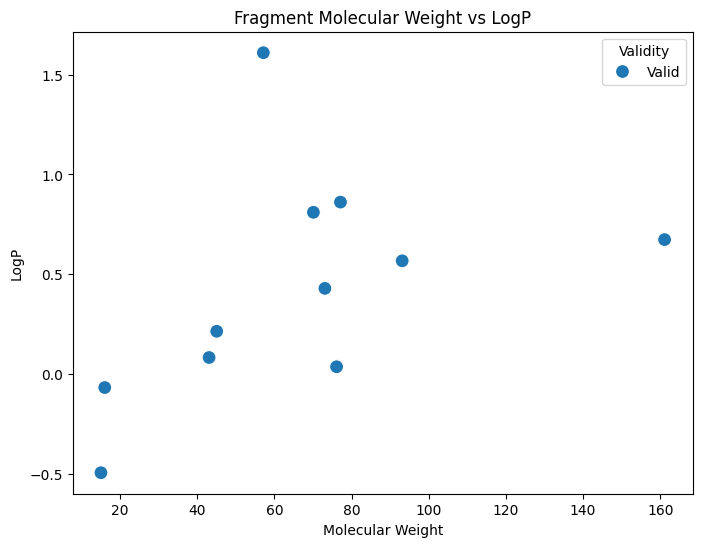

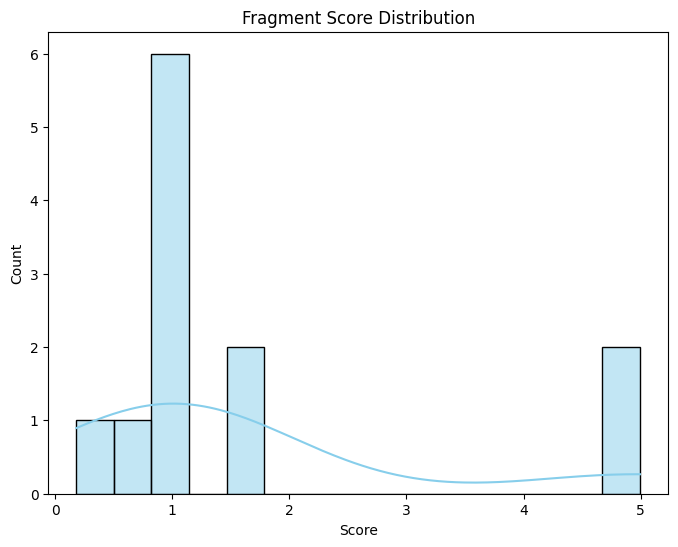

C:\Users\zulei\AppData\Local\Temp\ipykernel_10072\3998730504.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_frag, x='Validity', y='Score', palette='pastel')


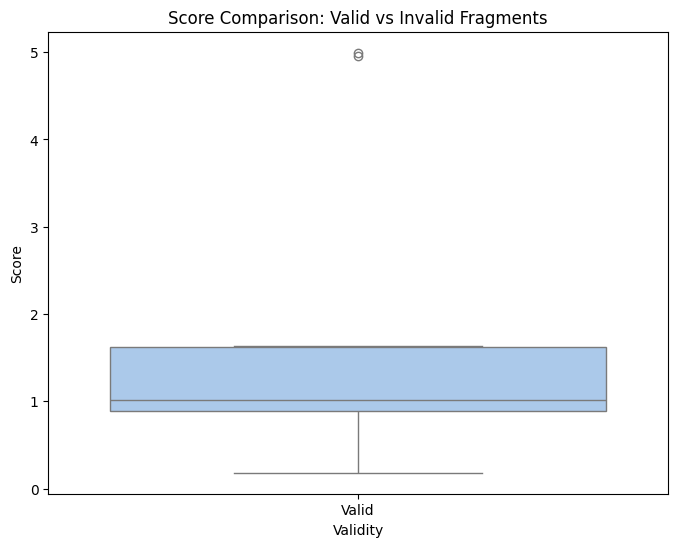

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate fragment library from example drugs
designer = FragmentBasedDesign()
smiles_list = ['CC(C)Cc1ccc(cc1)C(C)C(=O)O', 'CC(=O)Oc1ccccc1C(=O)O',
               'CC(=O)Nc1ccc(O)cc1', 'CC(=O)CC(c1ccccc1)c2c(O)c3ccccc3oc2=O']
fragment_library = designer.generate_fragment_library(smiles_list)
valid_fragments = designer.filter_fragments(fragment_library)
df_frag = designer.analyze_fragment_library(fragment_library)

# Add a column for valid/invalid
df_frag['Validity'] = df_frag['IsValid'].apply(lambda x: 'Valid' if x else 'Invalid')

# Scatter: MolecularWeight vs LogP
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_frag, x='MolecularWeight', y='LogP', hue='Validity', s=100)
plt.title('Fragment Molecular Weight vs LogP')
plt.xlabel('Molecular Weight')
plt.ylabel('LogP')
plt.legend(title='Validity')
plt.show()

# Distribution of fragment scores
plt.figure(figsize=(8,6))
sns.histplot(df_frag['Score'], bins=15, kde=True, color='skyblue')
plt.title('Fragment Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Boxplot: Score by validity
plt.figure(figsize=(8,6))
sns.boxplot(data=df_frag, x='Validity', y='Score', palette='pastel')
plt.title('Score Comparison: Valid vs Invalid Fragments')
plt.ylabel('Score')
plt.show()